In [ ]:
 %cd /content/

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir data

In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/MEDAI_MAR/lung_seg/3d_images.zip.zip -d /content/data
!unzip /content/data/3d_images.zip -d /content/data

Archive:  /content/drive/MyDrive/Colab Notebooks/MEDAI_MAR/lung_seg/3d_images.zip.zip
  inflating: /content/data/3d_images.zip  
Archive:  /content/data/3d_images.zip
 extracting: /content/data/IMG_0002.nii.gz  
 extracting: /content/data/IMG_0031.nii.gz  
 extracting: /content/data/IMG_0059.nii.gz  
 extracting: /content/data/IMG_0078.nii.gz  
 extracting: /content/data/MASK_0002.nii.gz  
 extracting: /content/data/MASK_0031.nii.gz  
 extracting: /content/data/MASK_0059.nii.gz  
 extracting: /content/data/MASK_0078.nii.gz  


In [ ]:
# !pip install torchview

In [ ]:
import os
import cv2
import torch
import warnings
import ipywidgets
import numpy as np
import pandas as pd
from torch import nn
import nibabel as nib
from glob import glob
from PIL import Image
from torchsummary import summary
import torch.optim as optim
# from unet3d import UNet3d
from IPython import display
import matplotlib.pyplot as plt
from skimage.util import montage
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from keras.preprocessing.image import ImageDataGenerator
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.tensorboard import SummaryWriter
import torch.optim.lr_scheduler as lr_scheduler
cfg_path= '/content/data'

<ipython-input-6-01817ce9d4d9>:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:

file_list= glob(cfg_path+"/*.gz", recursive= True)

In [ ]:
file_list

['/content/data/MASK_0059.nii.gz',
 '/content/data/MASK_0002.nii.gz',
 '/content/data/IMG_0059.nii.gz',
 '/content/data/IMG_0002.nii.gz',
 '/content/data/IMG_0078.nii.gz',
 '/content/data/IMG_0031.nii.gz',
 '/content/data/MASK_0078.nii.gz',
 '/content/data/MASK_0031.nii.gz']

In [ ]:
image_list= []
mask_list= []
for f in file_list:
  path_list=  f.split('/')[-1].split('_')[0]

  if 'MASK' in path_list:
    mask_list.append(f)
  else:
    image_list.append(f)


In [ ]:
mask_list

['/content/data/MASK_0059.nii.gz',
 '/content/data/MASK_0002.nii.gz',
 '/content/data/MASK_0078.nii.gz',
 '/content/data/MASK_0031.nii.gz']

In [ ]:
class Visualizer():
  def montage_nd(self, image):
    if len(image.shape) > 3:
      return montage(np.stack([self.montage_nd(img) for img in image], 0))
    elif len(image.shape) == 3:
      return montage(image)
    else:
      print('Input less than 3d image, returning original')
      return image
  def visualize(self, image, mask):
    fig, axs= plt.subplots(1, 2, figsize= (20,15 * 2))
    axs[0].imshow(self.montage_nd(image[..., 0]), cmap= 'bone')
    axs[1].imshow(self.montage_nd(mask[..., 0]), cmap= 'bone')
    plt.show()

In [ ]:

viz= Visualizer()

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, BASE_PATH, num_slices = 48):
        self.num_slices = num_slices
        self.images = self.read_data(glob(os.path.join(BASE_PATH, "IMG_*")))
        self.masks = self.read_data(glob(os.path.join(BASE_PATH,"MASK_*")), False)
        assert len(self.images) == len(self.masks)

    def read_data(self, paths, rescale = True, DS_FACT = 8):
        data = np.concatenate([nib.load(path).get_fdata()[:, ::DS_FACT, ::DS_FACT] for path in sorted(paths)], 0)
        if rescale: data = (data - data.min())/(data.max()-data.min()) * 255
        return np.expand_dims(data, -1).astype('float32') / 255

    def __len__(self):
        return len(self.images)-self.num_slices

    def __getitem__(self, idx):
        image = self.images[idx: idx + self.num_slices]
        mask = self.masks[idx: idx + self.num_slices]
        return image, mask


In [ ]:
cfg_path= '/content/data'
ds= TrainDataset(cfg_path)

In [ ]:
image,mask =  ds.__getitem__(0)
# sample= {'imidx': imidx, 'image': image, 'label': label}
print( image.shape,mask.shape)

(48, 64, 64, 1) (48, 64, 64, 1)


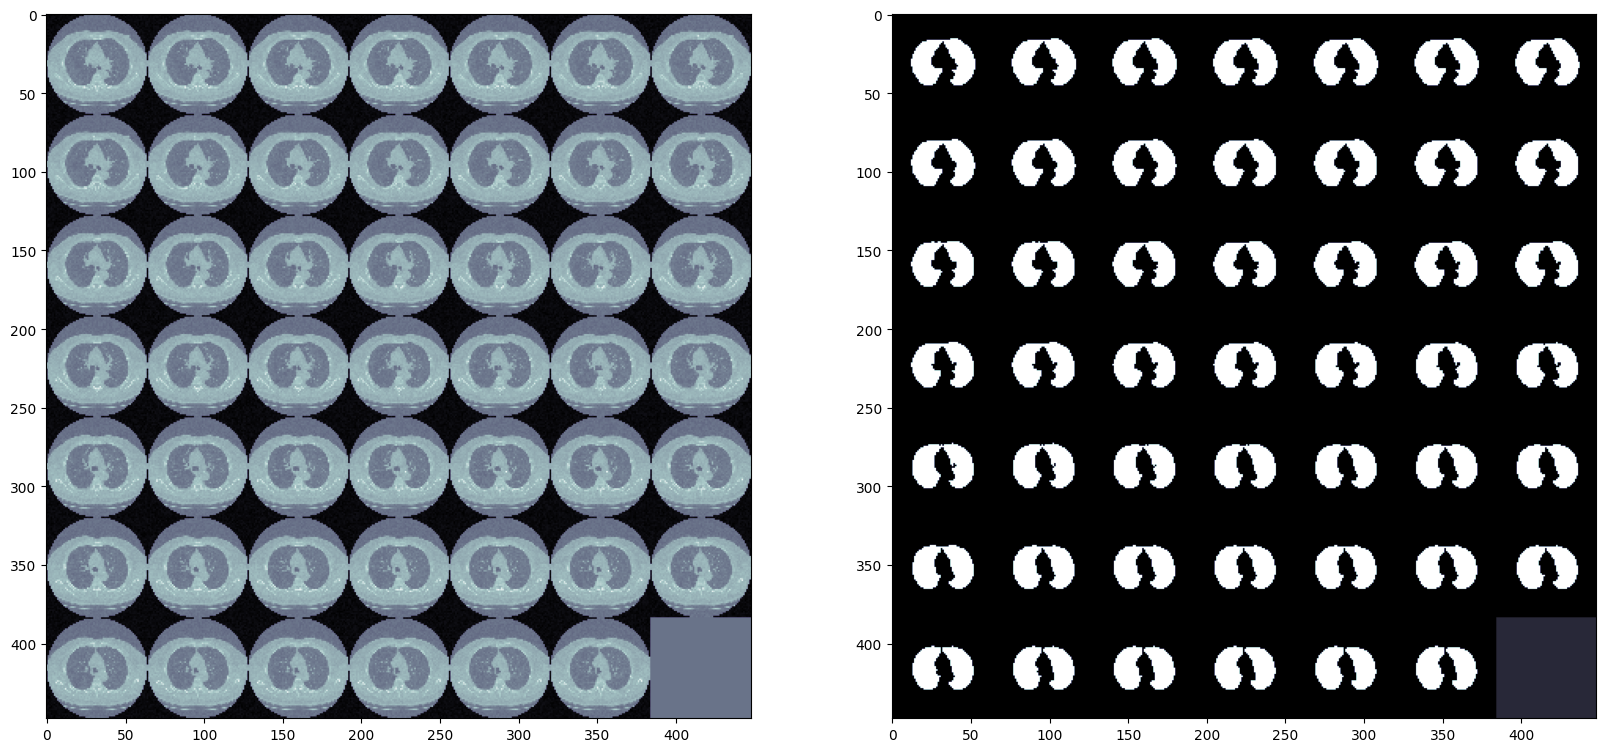

In [ ]:
idx= np.random.choice(len(ds))
image, mask= ds[idx]
viz.visualize(image, mask)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class REBNCONV(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dirate=1):
        super(REBNCONV,self).__init__()

        self.conv_s1 = nn.Conv3d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm3d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self,x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout

## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src,tar):

    src = F.upsample(src,size=tar.shape[2:],mode='trilinear')

    return src


### RSU-6 ###
class RSU6(nn.Module):#UNet07DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=32, out_ch=1):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool3d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool3d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool3d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool3d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        # self.pool5 = nn.MaxPool3d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        # self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        # self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,mid_ch,dirate=1)

        self.side1 = nn.Conv3d(mid_ch,out_ch,3,padding=1)
        self.side2 = nn.Conv3d(mid_ch,out_ch,3,padding=1)
        self.side3 = nn.Conv3d(mid_ch,out_ch,3,padding=1)
        self.side4 = nn.Conv3d(mid_ch,out_ch,3,padding=1)
        self.side5 = nn.Conv3d(mid_ch,out_ch,3,padding=1)
        self.side6 = nn.Conv3d(mid_ch,out_ch,3,padding=1)

        self.outconv = nn.Conv3d(6*out_ch,out_ch,1)


    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)

        # hx7 = self.rebnconv7(hx6)

        # hx6d =  self.rebnconv6d(torch.cat((hx7,hx6),1))
        # hx6dup = _upsample_like(hx6d,hx5)

        hx5d =  self.rebnconv5d(torch.cat((hx6,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))


        # if test:
        #     return F.sigmoid(d0), F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)
        return d0, d1, d2, d3, d4, d5, d6


In [ ]:

# import torch.nn.functional as F

# class ConvUnit(nn.Module):
#     """
#         Convolution Unit: (Conv3D -> BatchNorm -> ReLu) * 2
#     """
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.double_conv = nn.Sequential(
#             nn.Conv3d(in_channels, out_channels, kernel_size = 3, padding = 1),
#             nn.BatchNorm3d(out_channels),
#             nn.ReLU(inplace=True), # inplace=True means it changes the input directly, input is lost

#             nn.Conv3d(out_channels, out_channels, kernel_size = 3, padding = 1),
#             nn.BatchNorm3d(out_channels),
#             nn.ReLU(inplace=True)
#           )

#     def forward(self,x):
#         return self.double_conv(x)

# class EncoderUnit(nn.Module):
#     """
#     An Encoder Unit with the ConvUnit and MaxPool
#     """
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.MaxPool3d(2),
#             ConvUnit(in_channels, out_channels)
#         )
#     def forward(self, x):
#         return self.encoder(x)

# class DecoderUnit(nn.Module):
#     """
#     ConvUnit and upsample with Upsample or convTranspose
#     """
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
#         self.conv = ConvUnit(in_channels, out_channels)

#     def forward(self, x1, x2):
#         x1 = self.up(x1)

#         diffZ = x2.size()[2] - x1.size()[2]
#         diffY = x2.size()[3] - x1.size()[3]
#         diffX = x2.size()[4] - x1.size()[4]
#         x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

#         x = torch.cat([x2, x1], dim=1)
#         return self.conv(x)

# class OutConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

#     def forward(self, x):
#         return self.conv(x)

# class UNet3d(nn.Module):
#     def __init__(self, in_channels, n_classes, s_channels):
#         super().__init__()
#         self.in_channels = in_channels
#         self.n_classes = n_classes
#         self.s_channels = s_channels

#         self.conv = ConvUnit(in_channels, s_channels)
#         self.enc1 = EncoderUnit(s_channels, 2 * s_channels)
#         self.enc2 = EncoderUnit(2 * s_channels, 4 * s_channels)
#         self.enc3 = EncoderUnit(4 * s_channels, 8 * s_channels)
#         self.enc4 = EncoderUnit(8 * s_channels, 8 * s_channels)

#         self.dec1 = DecoderUnit(16 * s_channels, 4 * s_channels)
#         self.dec2 = DecoderUnit(8 * s_channels, 2 * s_channels)
#         self.dec3 = DecoderUnit(4 * s_channels, s_channels)
#         self.dec4 = DecoderUnit(2 * s_channels, s_channels)
#         self.out = OutConv(s_channels, n_classes)

#     def forward(self, x):
#         x1 = self.conv(x)
#         x2 = self.enc1(x1)
#         x3 = self.enc2(x2)
#         x4 = self.enc3(x3)
#         x5 = self.enc4(x4)

#         mask = self.dec1(x5, x4)
#         mask = self.dec2(mask, x3)
#         mask = self.dec3(mask, x2)
#         mask = self.dec4(mask, x1)
#         mask = self.out(mask)
#         return mask, x5

In [ ]:
net = RSU6(1,32, 1)

summary(net, input_size=(1, 64, 64, 64), batch_size= 1)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1         [1, 1, 64, 64, 64]              28
       BatchNorm3d-2         [1, 1, 64, 64, 64]               2
              ReLU-3         [1, 1, 64, 64, 64]               0
          REBNCONV-4         [1, 1, 64, 64, 64]               0
            Conv3d-5        [1, 32, 64, 64, 64]             896
       BatchNorm3d-6        [1, 32, 64, 64, 64]              64
              ReLU-7        [1, 32, 64, 64, 64]               0
          REBNCONV-8        [1, 32, 64, 64, 64]               0
         MaxPool3d-9        [1, 32, 32, 32, 32]               0
           Conv3d-10        [1, 32, 32, 32, 32]          27,680
      BatchNorm3d-11        [1, 32, 32, 32, 32]              64
             ReLU-12        [1, 32, 32, 32, 32]               0
         REBNCONV-13        [1, 32, 32, 32, 32]               0
        MaxPool3d-14        [1, 32, 16,

In [ ]:
class AugDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.aug_data_gen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.15,
            height_shift_range=0.15,
            shear_range=0.1,
            zoom_range=0.25,
            fill_mode='nearest',
            horizontal_flip=True,
            vertical_flip=False
        )

    def aug_data(self, x, y):
        print(x.shape, y.shape, "X and y shape")
        xy = torch.cat([x, y], dim = 1).squeeze(dim = -1).permute(0, 2, 3, 1)
        print(xy.shape, 'xy shape')
        img_gen = self.aug_data_gen.flow(xy, shuffle=True, seed=42, batch_size = len(x))
        # unblock
        xy_scat = torch.tensor(next(img_gen)).permute(0, 3, 1, 2).unsqueeze(dim = 1)
        print(xy_scat.shape, 'xy_scat shape')
        return xy_scat[:, :, :xy_scat.shape[2]//2], xy_scat[:, :, xy_scat.shape[2]//2:]

    def __iter__(self):
        for data in super().__iter__():
            data = self.aug_data(*data)
            yield data

In [ ]:
training = 0
num_epoch = 10
batch_size = 16
num_folds = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
warnings.filterwarnings("ignore")

In [ ]:
print(ds.__getitem__(0))

(array([[[[0.32387438],
         [0.3454408 ],
         [0.35206205],
         ...,
         [0.32519862],
         [0.33333334],
         [0.35035944]],

        [[0.3325766 ],
         [0.32954976],
         [0.34487325],
         ...,
         [0.34222475],
         [0.32122588],
         [0.3263337 ]],

        [[0.33617103],
         [0.32406357],
         [0.35603482],
         ...,
         [0.34506243],
         [0.33390087],
         [0.3533863 ]],

        ...,

        [[0.35925087],
         [0.32311767],
         [0.35773742],
         ...,
         [0.34222475],
         [0.33825198],
         [0.34184638]],

        [[0.3480893 ],
         [0.32482028],
         [0.35735908],
         ...,
         [0.33371168],
         [0.3535755 ],
         [0.34052214]],

        [[0.33976543],
         [0.3533863 ],
         [0.3581158 ],
         ...,
         [0.33200908],
         [0.34279227],
         [0.3554673 ]]],


       [[[0.32614452],
         [0.32765797],
         [0.3

In [ ]:
train_loaders = {}
valid_loaders = {}
train_folds= {}
valid_folds= {}
sss = StratifiedShuffleSplit(n_splits = num_folds, test_size = 0.2, random_state = 42)
splitter = sss.split(ds.images[:len(ds)], ds.masks[:len(ds)].sum(1).sum(1).sum(1).astype('int')%64)
for fold, (train_indices, valid_indices) in enumerate(splitter):
    train_folds[fold] = train_folds.get(fold, train_indices)
    valid_folds[fold] = valid_folds.get(fold, valid_indices)
    # Creating PT data samplers and loaders
    train_sampler = SubsetRandomSampler(train_folds[fold])
    valid_sampler = SubsetRandomSampler(valid_folds[fold])
    # train_loaders[fold] = AugDataLoader(ds, batch_size = batch_size, sampler = train_sampler)
    # valid_loaders[fold] = AugDataLoader(ds, batch_size = batch_size, sampler = valid_sampler)

In [ ]:
print(len(ds))
print(len(train_sampler))
print(len(valid_sampler))

1160
928
232


In [ ]:
train_loaders = AugDataLoader(ds, batch_size = 1, sampler = train_sampler)
dataiter = iter(train_loaders)
images, masks= next(dataiter)
print(type(images))
print(images.shape)
print(masks.shape)

torch.Size([1, 48, 64, 64, 1]) torch.Size([1, 48, 64, 64, 1]) X and y shape
torch.Size([1, 64, 64, 96]) xy shape
torch.Size([1, 1, 96, 64, 64]) xy_scat shape
<class 'torch.Tensor'>
torch.Size([1, 1, 48, 64, 64])
torch.Size([1, 1, 48, 64, 64])


In [ ]:
print(torch.unique(masks))

tensor([0.0000e+00, 5.3019e-05, 9.3165e-05,  ..., 9.9942e-01, 9.9963e-01,
        1.0000e+00])


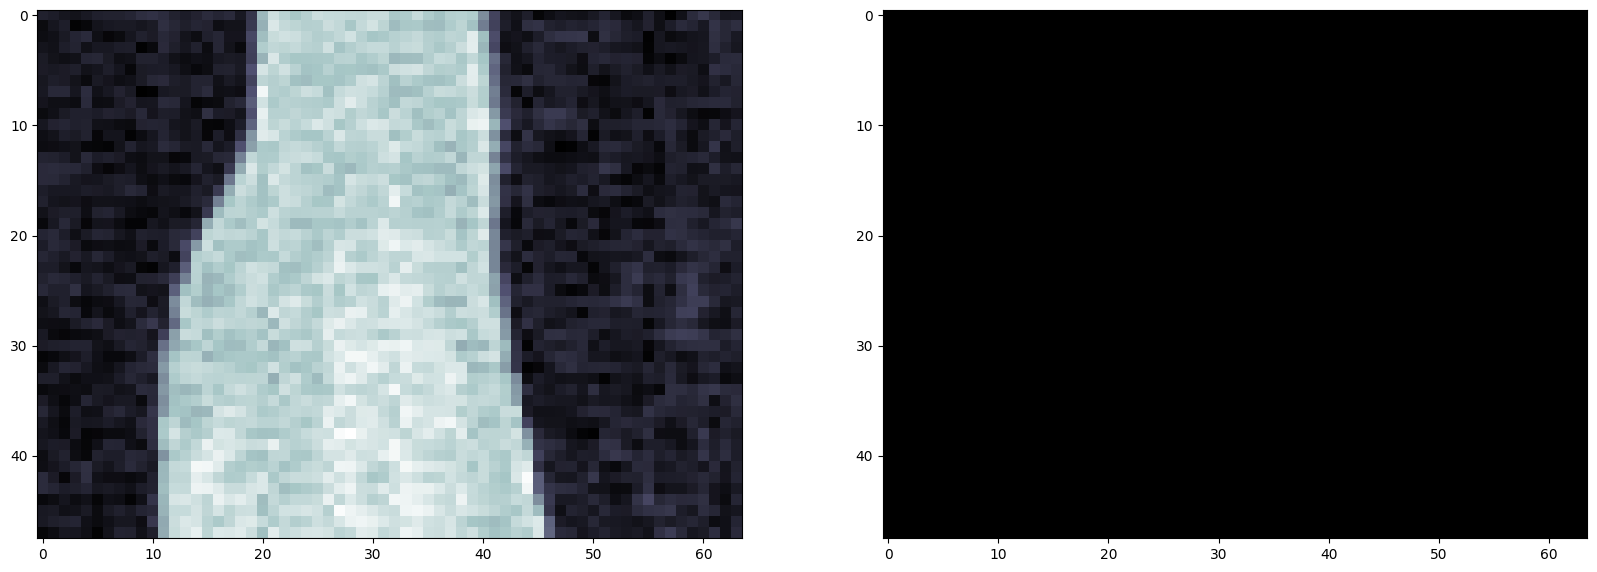

In [ ]:
viz.visualize(images, masks)

In [ ]:
# fold = np.random.choice(list(train_loaders))
# print(fold)
# images, mask = next(iter(train_loaders[fold]))
# print(images.shape)

In [ ]:
class FocalLoss(nn.Module):
  def __init__(self, alpha=1, gamma=0, logits=True, reduce=True):
      super(FocalLoss, self).__init__()
      self.alpha = alpha
      self.gamma = gamma
      self.reduce = reduce
      self.loss_fn = (nn.BCEWithLogitsLoss if logits else nn.BCELoss)(reduction = 'none')

  def forward(self, pred, target):
      BCE_loss = self.loss_fn(pred, target)
      pt = torch.exp(-BCE_loss)
      F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
      return F_loss.mean() if self.reduce else F_loss

In [ ]:
class BCEDiceLoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, input, target):
    print(input.shape)
    bce = F.binary_cross_entropy_with_logits(input, target)
    smooth = 1e-5
    input = torch.sigmoid(input)
    # input = torch.tanh(input)
    num = target.size(0)
    input = input.contiguous().view(num, -1)
    target = target.contiguous().view(num, -1)
    intersection = (input * target)
    dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return 0.5 * bce + dice


class LungNetLoss(nn.Module):
  def __init__(self):
    super(LungNetLoss, self).__init__()
    self.loss = BCEDiceLoss()

  def forward(self, d0, d1, d2, d3, d4, d5, d6, labels_v):
    loss0 = self.loss(d0, labels_v)
    loss1 = self.loss(d1, labels_v)
    loss2 = self.loss(d2, labels_v)
    loss3 = self.loss(d3, labels_v)
    loss4 = self.loss(d4, labels_v)
    loss5 = self.loss(d5, labels_v)
    loss6 = self.loss(d6, labels_v)
    loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
    print("l0: %3f, l1: %3f, l2: %3f, l3: %3f, l4: %3f, l5: %3f, l6: %3f\n" % (
        loss0.data, loss1.data, loss2.data, loss3.data, loss4.data, loss5.data, loss6.data,))
    return loss0, loss

In [ ]:
kwargs= {
    'name' : 'LungNet',
    'fold': 0,
    'epochs' : 30,
    'batch_size': 16,
    'input_channels': 1,
    'num_classes' : 1,
    'input_size': 64,
    'data_folder_name': 'train_data',
    'optimizer': 'Adam',
    'lr': 0.001,
    'nesterov': False,
    'momentum': 0.9,
    'weight_decay': 1e-4,
    'scheduler': 'CosineAnnealingLR',
    'min_lr': 1e-7,
    'factor': 0.1,
    'patience': 3,
    'milestones': '1,2',
    'gamma' : 2/3,
    'early_stopping' : 1,
    'num_workers':4
}

In [ ]:
class Model_Train():
  def __init__(self ,train_sampler, **kwargs):
      self.model_loss = LungNetLoss()
      self.model_name = kwargs['name']
      self.epoch_num = kwargs['epochs']
      self.save_frq = 1000  # save the model every 1000 iterations
      self.batch_size_train = kwargs['batch_size']
      self.epoch = 0
      self.model_dir= '/content/drive/MyDrive/Colab Notebooks/MEDAI_MAR/'

      self.root_dir = "/content/"
      self.log_dir = os.path.join(self.root_dir, "logs/my_board/" + os.sep)
      self.pthFile_name = "NONE"
      self.writer = SummaryWriter(self.log_dir)
      self.train_sampler= train_sampler

      # ------- 2. set the directory of training dataset --------
      # data_dir = os.path.join(self.root_dir, config['data_folder_name'] + os.sep)
      # tra_image_dir = os.path.join("images" + os.sep)
      # tra_label_dir = os.path.join("labels" + os.sep)
      # image_ext = ".jpg"
      # label_ext = ".bmp"
      # self.model_dir = os.path.join(self.root_dir, config['data_folder_name'], self.model_name + os.sep)
      # os.makedirs(self.model_dir, exist_ok=True)
      # tra_img_name_list = glob.glob(data_dir + tra_image_dir + "*" + image_ext)

      # tra_lbl_name_list = []
      # for img_path in tra_img_name_list:
      #     img_name = img_path.split(os.sep)[-1]
      #     aaa = img_name.split(".")
      #     bbb = aaa[0:-1]
      #     imidx = bbb[0]
      #     for i in range(1, len(bbb)):
      #         imidx = imidx + "." + bbb[i]
      #     tra_lbl_name_list.append(data_dir + tra_label_dir + imidx + label_ext)

      print("---")
      print("train images: ", len(self.train_sampler))
      print("train labels: ", len(self.train_sampler))
      print("---")
      self.train_num = len(train_sampler)
      # glioma_dataloader = Glioma_dataloader(img_name_list=tra_img_name_list, lbl_name_list=tra_lbl_name_list,
      #                                       transform= train_transforms)

                                      # transform=transforms.Compose([RescaleT(kwargs['input_size']), ToTensorLab(flag=0)]), )
      train_loaders[kwargs['fold']] = AugDataLoader(ds, batch_size = self.batch_size_train, sampler = self.train_sampler)
      self.lung_dataloader = train_loaders[kwargs['fold']]
      self.model = RSU6(in_ch = 1, out_ch= 1).cuda()
      # self.model= DexiNed().cuda()

      params = filter(lambda p: p.requires_grad, self.model.parameters())
      if kwargs['optimizer'] == 'Adam':
        self.optimizer = optim.Adam(params, lr=kwargs['lr'], betas=(0.9, 0.999), eps=1e-08,weight_decay=0, ) #weight_decay=config['weight_decay'])
      elif kwargs['optimizer'] == 'SGD':
        self.optimizer = optim.SGD(params, lr=kwargs['lr'], momentum=kwargs['momentum'], nesterov=kwargs['nesterov'],weight_decay=kwargs['weight_decay'])
      else:
        raise NotImplementedError

      if kwargs['scheduler'] == 'CosineAnnealingLR':
        self.scheduler = lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=kwargs['epochs'], eta_min=kwargs['min_lr'])
      elif kwargs['scheduler'] == 'ReduceLROnPlateau':
        self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, factor=kwargs['factor'], patience=kwargs['patience'],
                                                      verbose=1, min_lr=kwargs['min_lr'])
      elif kwargs['scheduler'] == 'MultiStepLR':
        self.scheduler = lr_scheduler.MultiStepLR(self.optimizer,
                                                milestones=[int(e) for e in kwargs['milestones'].split(',')],
                                                gamma=kwargs['gamma'])
      elif kwargs['scheduler'] == 'ConstantLR':
        self.scheduler = None
      else:
        raise NotImplementedError
  def model_train(self):
    if self.pthFile_name != "NONE":
      checkpoint = torch.load(self.pthFile_name)
      print("Pretrained Model - Started for training")
      if checkpoint["epoch"] > 0:
        self.model.load_state_dict(checkpoint["model_state_dict"])
        epoch = checkpoint["epoch"]
        print(f"=====> epoch:{epoch}")
        if torch.cuda.is_available():
          self.model.cuda()
          # ------- 4. define optimizer --------
        print("---define optimizer on retraining...")
        # self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,weight_decay=0, )
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
      else:
        if torch.cuda.is_available():
            self.model.cuda()
        # ------- 4. define optimizer --------
        print("---define optimizer...")
        #self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,weight_decay=0, )
    else:
      if torch.cuda.is_available():
        self.model.cuda()
      # ------- 4. define optimizer --------
      print("---define optimizer...")
      # self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, )

      # ------- 5. training process --------
    print("---start training...")
    ite_num = 0
    running_loss = 0.0
    running_tar_loss = 0.0
    ite_num4val = 0
    while self.epoch < self.epoch_num:
      self.model.train()
      for i, data in enumerate(self.lung_dataloader):
        ite_num = ite_num + 1
        ite_num4val = ite_num4val + 1

        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)


        # wrap them in Variable
        if torch.cuda.is_available():
          inputs_v, labels_v = (
          Variable(inputs.cuda(), requires_grad=False), Variable(labels.cuda(), requires_grad=False),)
        else:
          inputs_v, labels_v = Variable(inputs, requires_grad=False), Variable(labels, requires_grad=False)

        # y zero the parameter gradients
        self.optimizer.zero_grad()
        # forward + backward + optimize
        d0, d1, d2, d3, d4, d5, d6 = self.model(inputs_v)
        loss2, loss = self.model_loss(d0, d1, d2, d3, d4, d5, d6, labels_v)
        loss.backward()
        self.optimizer.step()
        # # print statistics
        running_loss += loss.data
        running_tar_loss += loss2.data
        # del temporary outputs and loss
        del d0, d1, d2, d3, d4, d5, d6,loss2, loss
        print("[epoch: %3d/%3d, batch: %5d/%5d, ite: %d] train loss: %3f, tar: %3f " % (
            self.epoch + 1, self.epoch_num, (i + 1) * self.batch_size_train, self.train_num, ite_num,
            running_loss / ite_num4val,
            running_tar_loss / ite_num4val,))

        self.writer.add_scalar("train loss", running_loss / ite_num4val, self.epoch + 1)
        self.writer.add_scalar("tar loss", running_tar_loss / ite_num4val)

        if ite_num % self.save_frq == 0:
          torch.save({"epoch": self.epoch, "model_state_dict": self.model.state_dict(),
                      "optimizer_state_dict": self.optimizer.state_dict(), },
                      self.model_dir + self.model_name + "_%d_at1_Unet3d_bce_itr_%d_train_%3f_tar_%3f.pth" % (
                      self.epoch, ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val,), )
          running_loss = 0.0
          running_tar_loss = 0.0
          self.model.train()  # resume train
          ite_num4val = 0

      self.epoch = self.epoch + 1
      self.scheduler.step()
      print(f"Current Learning Rate:{self.optimizer.param_groups[0]['lr']} ")

    torch.save(
        {"epoch": self.epoch, "model_state_dict": self.model.state_dict(),
          "optimizer_state_dict": self.optimizer.state_dict(), },
        self.model_dir + self.model_name + "_%d_at1_final_Unet3d_bce_itr_%d_train_%3f_tar_%3f.pth" % (
        self.epoch, ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val,), )


In [ ]:
model_obj = Model_Train(train_sampler, **kwargs)
model_obj.model_train()

Streaming output truncated to the last 5000 lines.
l0: 0.205109, l1: 0.176125, l2: 0.190084, l3: 0.262370, l4: 0.407094, l5: 0.658687, l6: 0.655755

[epoch:   2/ 30, batch:   416/  915, ite: 84] train loss: 3.324481, tar: 0.379684 
l0: 0.240549, l1: 0.217709, l2: 0.229882, l3: 0.288194, l4: 0.423715, l5: 0.619684, l6: 0.621807

[epoch:   2/ 30, batch:   432/  915, ite: 85] train loss: 3.316447, tar: 0.378047 
l0: 0.353603, l1: 0.306317, l2: 0.337929, l3: 0.423481, l4: 0.524853, l5: 0.699771, l6: 0.699901

[epoch:   2/ 30, batch:   448/  915, ite: 86] train loss: 3.316789, tar: 0.377763 
l0: 0.208819, l1: 0.174217, l2: 0.194961, l3: 0.260111, l4: 0.382659, l5: 0.615494, l6: 0.620095

[epoch:   2/ 30, batch:   464/  915, ite: 87] train loss: 3.306899, tar: 0.375821 
l0: 0.157059, l1: 0.118525, l2: 0.142539, l3: 0.200838, l4: 0.315917, l5: 0.558671, l6: 0.559000

[epoch:   2/ 30, batch:   480/  915, ite: 88] train loss: 3.292645, tar: 0.373335 
l0: 0.127570, l1: 0.094759, l2: 0.110728, l3

In [ ]:
path_= '/content/drive/MyDrive/Colab Notebooks/MEDAI_MAR/LungNet_30_at1_final_Unet3d_bce_itr_1740_train_1.757873_tar_0.114308.pth'

sample_model =RSU6(1, 32, 1).cuda()

checkpoint = torch.load(path_)

sample_model.load_state_dict(checkpoint['model_state_dict'])
optimizer = optim.Adam(sample_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,weight_decay=0, )

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print("Model loaded!")

Model loaded!


In [ ]:
idx= np.random.randint(len(ds))
image, mask= ds[idx]
print(image.shape)
img= torch.tensor(image, dtype= torch.float32).permute(3, 0, 1, 2).cuda()
pred= sample_model(img[None].float())[0].detach().cpu()
pred= pred.squeeze(0).permute(1, 2, 3, 0)

(64, 64, 64, 1)
torch.Size([1, 1, 64, 64, 64])
torch.Size([64, 64, 64, 1])
torch.Size([64, 64, 64, 1])


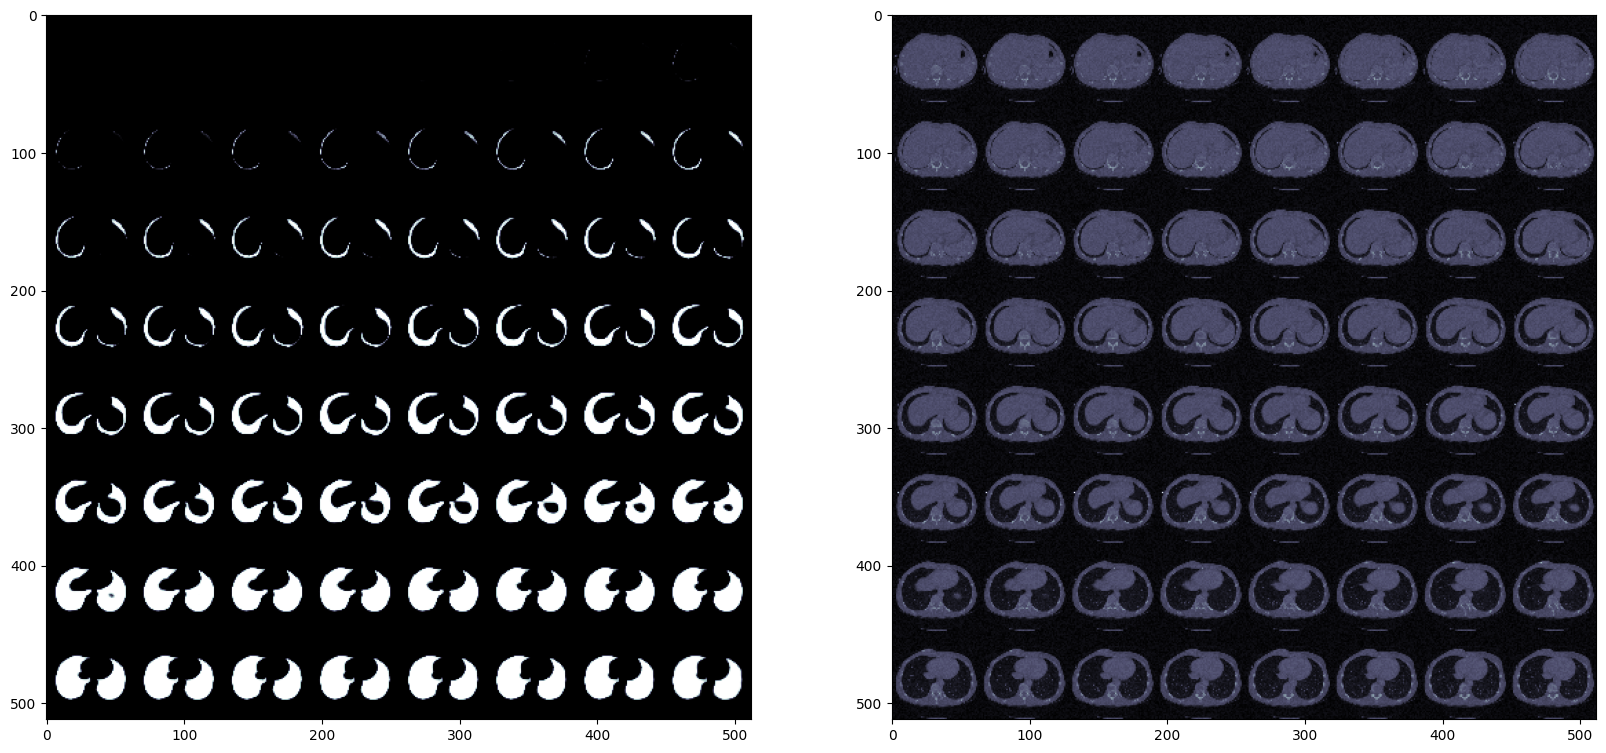

In [ ]:
viz.visualize(torch.sigmoid(pred) ,image)

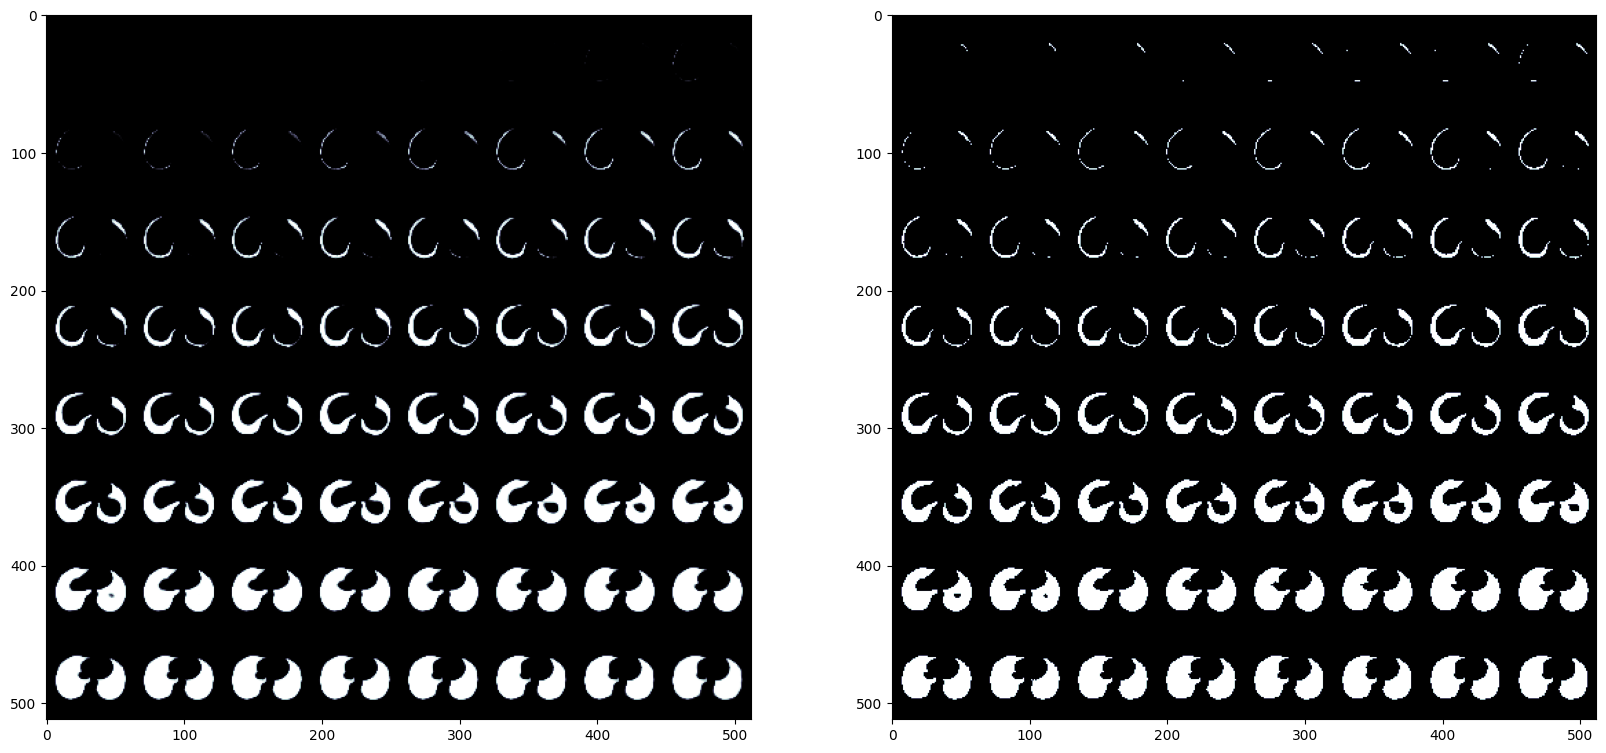

In [ ]:
viz.visualize(torch.sigmoid(pred) ,mask)

In [ ]:
class TestModel:
  def __init__(self, test_img_name_list, test_lbl_name_list,**kwargs):
    self.threshold_value = kwargs['threshold_value']

    self.model_name = kwargs['name']
    self.batch_size_train = kwargs['batch_size']
    self.root_dir = "/content/"

    self.prediction_dir = os.path.join(self.root_dir, "Results", self.model_name + "Masks_results" + os.sep)
    self.test_img_name_list = test_img_name_list

    tra_label_dir = os.path.join("gt_masks" + os.sep)
    label_ext = ".bmp"
    self.data_len = len(test_lbl_name_list)
    self.glioma_dataloader = DataLoader(test_ds, batch_size=self.batch_size_train, shuffle=False , num_workers=kwargs['num_workers'])
    self.model = RSU6(in_ch = 1, out_ch= 1).cuda()
    checkpoint = torch.load(kwargs['model_path'], map_location=torch.device('cpu'))
    self.model.load_state_dict(checkpoint["model_state_dict"])
    self.model.cuda()
    self.model.eval()
  def normPRED(self, d):
    ma = torch.max(d)
    mi = torch.min(d)
    dn = (d - mi) / (ma - mi)
    return dn
  def save_output(self, image_name, pred, d_dir ,i_test =0 ):
    predict = pred
    predict = predict.squeeze()
    predict_np = predict.cpu().data.numpy()
    predict_np[predict_np >= self.threshold_value] = 1
    predict_np[predict_np < self.threshold_value] = 0
    # print(predict_np.shape)
    im = Image.fromarray(predict_np * 255).convert("RGB")
    img_name = image_name.split(os.sep)[-1]
    image = io.imread(image_name)
    imo = im.resize((image.shape[1], image.shape[0]), Image.ANTIALIAS)
    # pb_np = np.array(imo)
    aaa = img_name.split(".")
    bbb = aaa[0:-1]
    imidx = bbb[0]
    for i in range(1, len(bbb)):
        imidx = imidx + "." + bbb[i]
    print(" Image number" ,i_test, d_dir, imidx)
    imo.save(d_dir + imidx + ".png", quality=1000)

  def model_inf(self):
    print("=== 04. Convert an image to an image list. ===")

    for i_test, data_test in enumerate(self.glioma_dataloader):
      inputs_test, gt_labels = data_test
      inputs_test = inputs_test.type(torch.FloatTensor)
      # if self.cuda_flag:
      inputs_test = Variable(inputs_test.cuda())
      gt = Variable(gt_labels.cuda(), requires_grad=False)
      # else:
      #   inputs_test = Variable(inputs_test)
      #   gt = Variable(gt_labels, requires_grad=False)

      # if self.onnx_flag:
      #   torch.onnx.export(self.model,  # model being run
      #                     inputs_test,  # model input (or a tuple for multiple inputs)
      #                     "glioma_net.onnx",
      #                     # where to save the model (can be a file or file-like object)
      #                     export_params=True,  # store the trained parameter weights inside the model file
      #                     opset_version=10,  # the ONNX version to export the model to
      #                     do_constant_folding=True,  # whether to execute constant folding for optimization
      #                     input_names=['input'],  # the model's input names
      #                     output_names=['output'],  # the model's output names
      #                     dynamic_axes={'input': {0: 'batch_size'},  # variable length axes
      #                                   'output': {0: 'batch_size'}})
      #   print('onnx done')
      #   exit()

      d1, d2, d3, d4, d5, d6, d7 = self.model(inputs_test, test=True)
      # normalization
      pred = d1[:, 0, :, :]
      pred = self.normPRED(pred)

      # save results to test_results folder
      if not os.path.exists(self.prediction_dir):
        os.makedirs(self.prediction_dir, exist_ok=True)
      self.save_output(self.test_img_name_list[i_test], pred, self.prediction_dir , i_test )
      del d1, d2, d3, d4, d5, d6, d7

In [ ]:
# class DiceScore(nn.Module):
#     def __init__(self, smooth = 1e-6):
#         super().__init__()
#         self.smooth = smooth

#     def forward(self, pred, target):
#         pred = torch.sigmoid(pred)
#         batch_size = target.size(0)
#         pred = pred.contiguous().view(batch_size,-1)
#         target = target.contiguous().iview(batch_size,-1)
#         intersection = (pred * target)
#         score = (2. * intersection.sum(1) + self.smooth) / (pred.sum(1) + target.sum(1) + self.smooth)
#         return score.mean()

In [ ]:
# models = {}
# optimizers = {}
# schedulers = {}
# metric = DiceScore()
# criterion = FocalLoss()

# for fold in tqdm(range(num_folds)):
#     models[fold] = UNet3d(in_channels = 1, n_classes = 1, s_channels = 32).to(device)
#     params = [p for n, p in models[fold].named_parameters() if p.requires_grad]
#     optimizers[fold] = torch.optim.Adam(params, lr=1e-3)
#     schedulers[fold] = torch.optim.lr_scheduler.StepLR(optimizers[fold], step_size=90, gamma=0.1, last_epoch=-1)

  0%|          | 0/1 [00:00<?, ?it/s]

0


In [ ]:
# def valid(fold):
#     total_loss = 0
#     total_score = 0
#     models[fold].eval()
#     loader = tqdm(valid_loaders[fold], desc = f"Validating fold {fold+1}")
#     for idx, (images, targets) in enumerate(loader, start=1):
#         images = images.to(device)
#         targets = targets.to(device)
#         # Execute
#         with torch.no_grad():
#             outputs, _ = models[fold](images)
#         loss = criterion(outputs, targets).item()
#         score = metric(outputs, targets).item()
#         loss += 1 - score
#         total_loss += loss
#         total_score += score
#         # print statistics
#         loader.set_postfix_str(f"Score: {score:.4f} | Loss: {loss:.4f}")
#         loader.update()
#         # Clear variable
#         del images; targets; del outputs; del loss; del score
#     loader.write(f"Validated fold {fold+1} | Score: {total_score/idx:.4f} | Loss: {total_loss/idx:.4f}")
#     return total_score/idx, total_loss/idx

In [ ]:
# def train(fold):
#     total_loss = 0
#     total_score = 0
#     models[fold].train()
#     loader = tqdm(train_loaders[fold], desc = f"Training fold {fold+1}")
#     for idx, (images, targets) in enumerate(loader, start=1):
#         images = images.to(device)
#         targets = targets.to(device)
#         # Execute
#         outputs, _ = models[fold](images)
#         loss = criterion(outputs, targets)
#         score = metric(outputs, targets)
#         loss += 1 - score
#         total_loss += loss.item()
#         total_score += score.item()
#         # Optimize + Backward
#         optimizers[fold].zero_grad()
#         loss.backward()
#         optimizers[fold].step()
#         # print statistics
#         loader.set_postfix_str(f"Score: {score:.4f} | Loss: {loss:.4f}")
#         loader.update()
#         # Clear variable
#         del images; targets; del outputs; del loss; del score
#     loader.write(f"Trained fold {fold+1} | Score: {total_score/idx:.4f} | Loss: {total_loss/idx:.4f}")
#     valid_score, valid_loss = valid(fold)
#     schedulers[fold].step()
#     return total_score/idx, total_loss/idx, valid_score, valid_loss

In [ ]:
# for fold in range(num_folds):
#   train_score, train_loss, valid_score, valid_loss = train(fold)

In [ ]:
inp= torch.rand(16, 3, 224, 224, 224)
targ= torch.rand(16, 1, 224, 224, 224)
num= targ.size(0)
inp= inp.view(num, -1)

inp.shape

torch.Size([16, 33718272])